In [ ]:
from google.colab import drive
import warnings
from sklearn.exceptions import ConvergenceWarning

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt

# 0.Introducción

El objetivo de este notebook es ejemplificar un caso en el que se da overfitting y el uso de técnicas de regularización para corregir este problema encontrando un equilibrio entre el sesgo y la varianza.

Vamos a trabajar con un conjunto de datos de expresiones de genes de pacientes con leucemia. La variable a predecir es la expresión del gen MYC en base a la expresión de otros genes (>14k genes).

El oncogén MYC es un gen que desempeña un papel crucial en el desarrollo del cáncer. En su estado normal regula funciones celulares esenciales, como la proliferación celular y la apoptosis (muerte celular programada), pero cuando se muta o se sobreexpresa, se convierte en un oncogén que promueve el crecimiento celular descontrolado y el desarrollo de tumores. El estudio de MYC y su función en el cáncer es un campo de investigación activo ya que se busca comprender mejor su función y encontrar formas de dirigirse a él en el tratamiento del cáncer.

In [ ]:
# Montamos google drive
drive.mount('/content/gdrive', force_remount=True)

# Ignorar las advertencias de convergencia
warnings.filterwarnings("ignore", category=ConvergenceWarning)

Mounted at /content/gdrive


In [ ]:
# Leemos los datos con los que vamos a trabajar
df = pd.read_table("/content/gdrive/MyDrive/Colab Notebooks/4GA: Bootcamp DS/16.Regularized Linear Regression/expresiones.csv", sep=',')

In [ ]:
# Total de filas y de columnas
df.shape

(1875, 14208)

In [ ]:
# Estadísticas básicas
df.describe()

,DDR1,MIR4640,RFC2,HSPA6,PAX8,GUCA1A,MIR5193,UBA7,THRA,PTPN21,...,MROH7-TTC4,RBM12B,LOC102725263,LOC100129924,FAM86B1,FAM86B2,FAM86DP,FAM86FP,SNHG17,LOC100505915
count,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,...,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000,1875.000000
mean,7.502462,7.502462,7.087112,6.821060,6.546312,5.568841,9.424491,9.424491,6.418414,5.277271,...,6.813076,4.944160,6.600007,6.301037,7.093855,7.093855,7.093855,7.093855,7.688081,6.483545
std,0.710616,0.710616,0.389614,0.740807,0.170336,0.234568,0.714300,0.714300,0.178257,0.158924,...,0.384074,0.433359,0.380310,0.250330,0.433383,0.433383,0.433383,0.433383,0.632775,0.580234
min,6.046788,6.046788,5.870192,5.713043,5.445176,4.865600,6.826737,6.826737,5.797906,4.735825,...,5.655635,4.118449,5.395731,5.395229,5.709857,5.709857,5.709857,5.709857,6.194073,5.406979
25%,6.944669,6.944669,6.803295,6.390176,6.430230,5.407310,8.919127,8.919127,6.299045,5.170276,...,6.557057,4.648130,6.358234,6.131280,6.787060,6.787060,6.787060,6.787060,7.213817,6.113720
50%,7.313142,7.313142,7.037310,6.590823,6.537542,5.569164,9.435480,9.435480,6.408894,5.268480,...,6.821080,4.831457,6.560799,6.306107,7.080039,7.080039,7.080039,7.080039,7.637056,6.339491
75%,7.986692,7.986692,7.326799,6.930017,6.657383,5.729729,9.936661,9.936661,6.525294,5.372049,...,7.058153,5.122855,6.833514,6.460215,7.389086,7.389086,7.389086,7.389086,8.090582,6.710589
max,10.219645,10.219645,8.981703,12.006646,7.480305,6.382956,11.481737,11.481737,7.101508,6.373844,...,8.422725,7.328832,8.340330,7.378341,8.670503,8.670503,8.670503,8.670503,9.899646,9.190642


In [ ]:
# Definimos X e y
X = df.drop(columns='MYC', axis=1)
y = df['MYC']

# Formamos los conjuntos de entrenamiento y de testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

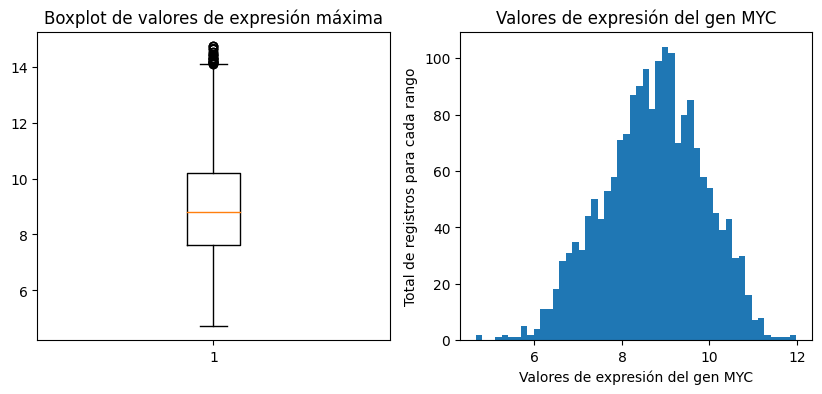

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.boxplot(df.max())
plt.title('Boxplot de valores de expresión máxima')
plt.subplot(1, 2, 2)
plt.hist(y,50)
plt.xlabel('Valores de expresión del gen MYC')
plt.ylabel('Total de registros para cada rango')
plt.title('Valores de expresión del gen MYC')
plt.show()

In [ ]:
# Crea una instancia del StandardScaler
scaler = StandardScaler()

# Ajusta el escalador a los datos de entrenamiento y transforma los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)

# Transforma los datos de prueba utilizando el mismo escalador
X_test_scaled = scaler.transform(X_test)

# 1.Modelo de regresión lineal base

In [ ]:
# Entrenamos un modelo de regresión lineal sin regularización
m_linear = LinearRegression().fit(X_train_scaled, y_train)

# Realizamos predicciones sobre el conjunto de entrenamiento y de testeo
yhat_train_linear = m_linear.predict(X_train_scaled)
yhat_linear = m_linear.predict(X_test_scaled)

In [ ]:
# Creamos una función que mida el error en ambos conjuntos y la diferencia
def get_metrics(yhat, y_test, yhat_train, y_train):
  metrics_train = r2_score(y_train, yhat_train), median_absolute_error(y_train, yhat_train), mean_absolute_percentage_error(y_train, yhat_train)*100
  metrics_test = r2_score(y_test, yhat), median_absolute_error(y_test, yhat), mean_absolute_percentage_error(y_test, yhat)*100
  metrics_diff = list(map(lambda x: x[1]-x[0], zip(metrics_train, metrics_test)))
  return pd.DataFrame(data=[metrics_train, metrics_test, metrics_diff], columns=['R2', 'Median AE', 'MAPE'], index=['Train set', 'Test set', 'Diferencia'])

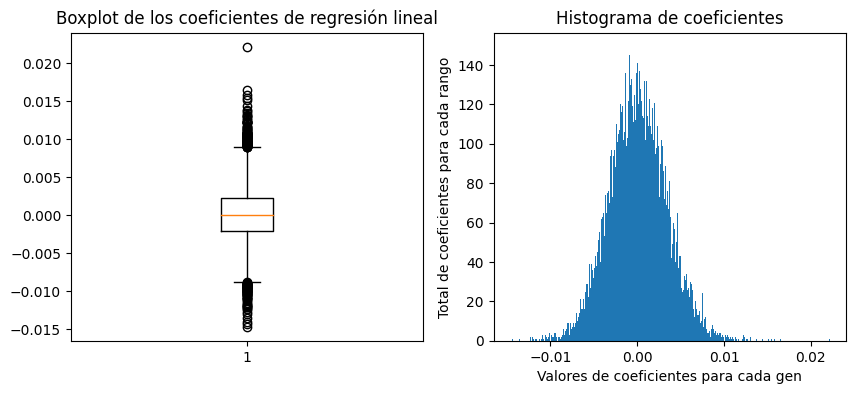

In [ ]:
# Graficamos los coeficientes calculados
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.boxplot(m_linear.coef_)
plt.title('Boxplot de los coeficientes de regresión lineal')
plt.subplot(1, 2, 2)
plt.hist(m_linear.coef_,500)
plt.xlabel('Valores de coeficientes para cada gen')
plt.ylabel('Total de coeficientes para cada rango')
plt.title('Histograma de coeficientes')
plt.show()

In [ ]:
# Métricas obtenidas para ambos conjuntos así como su diferencia
get_metrics(yhat_linear, y_test, yhat_train_linear, y_train)

,R2,Median AE,MAPE
Train set,1.000000,5.329071e-15,7.675175e-14
Test set,0.731067,3.412906e-01,5.351933e+00
Diferencia,-0.268933,3.412906e-01,5.351933e+00


Observaciones para el modelo sin regularización:
- El modelo de regresión lineal padece de sobreajuste (overfitting), esto puede verse en la **alta varianza** que existe en las métricas obtenidas para los conjuntos de entrenamiento y testeo. Es dedir, está memorizando y no generalizando.

- El modelo tiene un **bajo sesgo**, ya que lo hace extremadamente bien en el conjunto de entrenamiento (capturando incluso el ruido) y moderadamente bien en el conjunto de prueba.

A continuación vamos a aplicar técnicas de regularización para intentar reducir la varianza sin incurrir en un alto sesgo (lograr un mejor equilibrio entre sesgo y varianza).

La "regularización" se origina del concepto de "regularizar" o imponer restricciones adicionales en los modelos con el propósito de prevenir un ajuste excesivo a los datos de entrenamiento y mejorar la capacidad de generalización a datos no vistos. Esta técnica implica la adición de términos suplementarios a la función de costo o pérdida del modelo durante el proceso de entrenamiento. Estos términos adicionales penalizan valores extremos o inusuales en los coeficientes del modelo, lo que a su vez ayuda a restringir la complejidad del modelo y a evitar que se adapte en exceso a los datos de entrenamiento. Entre los métodos más destacados se encuentran la regularización L1 (Lasso), la regularización L2 (Ridge) y ElasticNet, que combina elementos de L1 y L2.

# 2.Lasso regularization L1
Modelo lineal regularizado de Lasso (L1): La regularización L1 es útil para la selección de características y la reducción de la dimensionalidad, ya que tiende a establecer coeficientes exactamente en cero eliminando así las características menos relevantes del modelo, lo cual simplifica el modelo y mejora la interpretabilidad.



In [ ]:
# Entrenamos un modelo LassoCV debemos encontrar un buen valor de alpha (determina la intensidad de la regularización) mediante validación cruzada
m_lasso = LassoCV(alphas=np.logspace(-6, 6, 10), cv=5, random_state=42, n_jobs=-1).fit(X_train_scaled, y_train)

# Realizamos predicciones sobre el conjunto de entrenamiento y de testeo
yhat_train_lasso = m_lasso.predict(X_train_scaled)
yhat_lasso = m_lasso.predict(X_test_scaled)

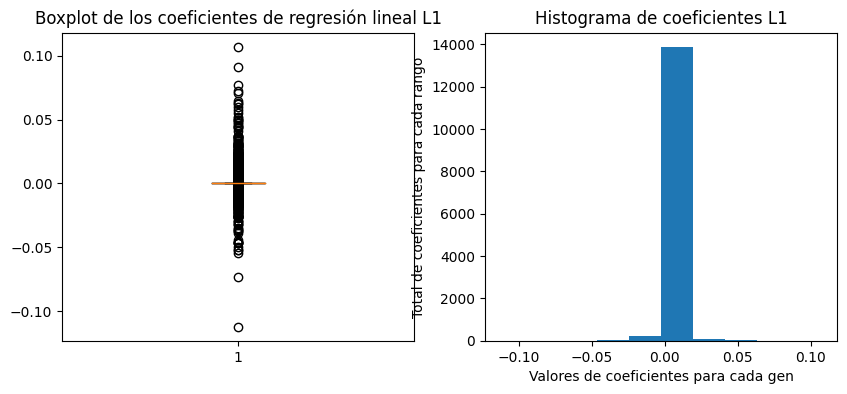

In [ ]:
# Graficamos los coeficientes calculados
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.boxplot(m_lasso.coef_)
plt.title('Boxplot de los coeficientes de regresión lineal L1')
plt.subplot(1, 2, 2)
plt.hist(m_lasso.coef_,10)
plt.xlabel('Valores de coeficientes para cada gen')
plt.ylabel('Total de coeficientes para cada rango')
plt.title('Histograma de coeficientes L1')
plt.show()

In [ ]:
print(f'Mejor alpha encontrado: {m_lasso.alpha_}')
print(f'Coeficientes: {m_lasso.coef_}')

Mejor alpha encontrado: 0.01
Coeficientes: [-0. -0. -0. ...  0.  0.  0.]


In [ ]:
# Porcentaje de variables canceladas y variables que usa el modelo
print(f'El porcentaje de variables canceladas es: {round(len(m_lasso.coef_[np.abs(m_lasso.coef_)==0])/len(m_lasso.coef_)*100,2)}%')
print(f'El modelo utiliza {len(m_lasso.coef_[np.abs(m_lasso.coef_)>0])} variables.')

El porcentaje de variables canceladas es: 95.3%
El modelo utiliza 668 variables.


In [ ]:
get_metrics(yhat_lasso, y_test, yhat_train_lasso, y_train)

,R2,Median AE,MAPE
Train set,0.919154,0.203089,2.992888
Test set,0.711551,0.390809,5.794560
Diferencia,-0.207603,0.187720,2.801673


Observaciones para el modelo con regularización Lasso:
- El modelo no ha memorizado los datos de entrenamiento. El modelo generaliza adecuadamente a datos no vistos, pero no tan bien como lo hace en los datos de entrenamiento, esto da lugar a que exista cierta varianza entre las métricas obtenidas en los conjuntos de entrenamiento y prueba.

- El modelo tiene un **bajo sesgo**, ya que el modelo captura adecuadamente la tendencia en los datos y hace predicciones precisas tanto en el conjunto de entrenamiento como en el de prueba.

En términos generales, el equilibrio entre sesgo y varianza parece ser razonable en este modelo.

# 3.Ridge regularization L2

Modelo lineal regularizado de Ridge (L2): Añade una penalización igual al cuadrado de la magnitud de los coeficientes. Esto tiende a reducir los coeficientes pero no los hace exactamente cero, por lo que todas las características se mantienen en el modelo.

In [ ]:
# Entrenamos un modelo LassoCV
m_ridge = RidgeCV(alphas=np.logspace(-6, 6, 10), cv=5).fit(X_train_scaled, y_train)

# Realizamos predicciones sobre el conjunto de entrenamiento y de testeo
yhat_train_ridge = m_ridge.predict(X_train_scaled)
yhat_ridge = m_ridge.predict(X_test_scaled)

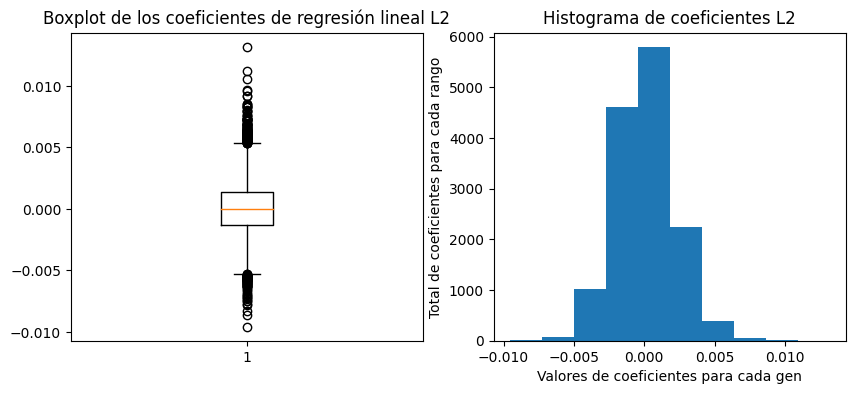

In [ ]:
# Graficamos los coeficientes calculados
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.boxplot(m_ridge.coef_)
plt.title('Boxplot de los coeficientes de regresión lineal L2')
plt.subplot(1, 2, 2)
plt.hist(m_ridge.coef_,10)
plt.xlabel('Valores de coeficientes para cada gen')
plt.ylabel('Total de coeficientes para cada rango')
plt.title('Histograma de coeficientes L2')
plt.show()

In [ ]:
print(f'Mejor alpha encontrado: {m_ridge.alpha_}')
print(f'Coeficientes: {m_ridge.coef_}')

Mejor alpha encontrado: 2154.434690031878
Coeficientes: [-0.00148508 -0.00148508 -0.00216011 ...  0.00184847  0.0024247
  0.00099424]


In [ ]:
# Porcentaje de variables canceladas y variables que usa el modelo
print(f'El porcentaje de variables canceladas es: {round(len(m_ridge.coef_[np.abs(m_ridge.coef_)==0])/len(m_ridge.coef_)*100,2)}%')
print(f'El modelo utiliza {len(m_ridge.coef_[np.abs(m_ridge.coef_)>0])} variables.')

El porcentaje de variables canceladas es: 0.0%
El modelo utiliza 14207 variables.


In [ ]:
get_metrics(yhat_ridge, y_test, yhat_train_ridge, y_train)

,R2,Median AE,MAPE
Train set,0.961295,0.134055,2.026451
Test set,0.723634,0.358036,5.536782
Diferencia,-0.237661,0.223980,3.510330


Observaciones para el modelo con regularización Ridge:

- El modelo con regularización Ridge se comporta de manera parecida al modelo con regularización Lasso, ya que el equilibrio entre sesgo y varianza parece ser razonable.

- Si bien Ridge presenta un sesgo menor (las métricas obtenidas en train y test son mejores que las obtenidas con Lasso) este presenta una varianza más elevada que Lasso en las predicciones (la diferencia en las métricas de train y test es mayor que la diferencia que se obtiene con Lasso).

La elección final del modelo recae en el equipo de desarrollo de ML, que debe considerar el equilibrio entre sesgo y varianza, así como los objetivos del proyecto.

# Extra: Proceso de validación cruzada para encontrar un buen valor de alpha

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png">

Lectura recomendada:

https://salvatore-raieli.medium.com/a-complete-guide-to-linear-regression-using-gene-expression-data-regularization-f980ba6b11f7